## Internet of Things Traffic Prediction using RNN Models

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Import libraries for metrics and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:
# Load the dataset
df = pd.read_csv("../dataset/esp32_1_data.csv")
df.head() # Display the first few rows of the dataset

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:13,28.3,81.5,0.242920,0.054,0.0,-61
1,2025-05-12 | 10:14:15,28.5,80.2,0.336914,0.054,0.0,-61
2,2025-05-12 | 10:14:17,28.5,80.2,0.206543,0.054,0.0,-62
3,2025-05-12 | 10:14:19,28.5,80.2,0.434326,0.054,0.0,-65
4,2025-05-12 | 10:14:21,28.5,80.2,0.428711,0.054,0.0,-55


### Data Preprocessing

In [4]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Set the timestamp as the index
df.set_index("timestamp", inplace=True)
df_resampled = df.resample("min").mean()

# Check the shape of the dataset
print(f"Shape of the dataset: {df_resampled.shape}")

# Check the missing values in the dataset
print(f"Missing values in the dataset:\n{df_resampled.isnull().sum()}")

Shape of the dataset: (1896, 6)
Missing values in the dataset:
temperature              117
humidity(%)              117
latency(ms)              117
throughput(bytes/sec)    117
packet_loss(%)           117
rssi(dBm)                117
dtype: int64


In [26]:
# Check the mean and standard deviation for each columns
print(f"Mean for each column\n{df_resampled.mean()}\n")
print(f"Standard deviation for each column\n{df_resampled.std()}\n")

# Check the amplitude for each column using the max and min values
print(f"Amplitude for each column\n{df_resampled.max() - df_resampled.min()}\n")

Mean for each column
temperature              30.909752
humidity(%)              74.027475
latency(ms)               0.277156
throughput(bytes/sec)     0.054000
packet_loss(%)            0.000000
rssi(dBm)               -57.561011
dtype: float64

Standard deviation for each column
temperature              8.192029e-01
humidity(%)              3.102479e+00
latency(ms)              2.054129e-02
throughput(bytes/sec)    1.302496e-17
packet_loss(%)           0.000000e+00
rssi(dBm)                1.386860e+00
dtype: float64

Amplitude for each column
temperature              4.152174e+00
humidity(%)              1.379421e+01
latency(ms)              2.098918e-01
throughput(bytes/sec)    2.775558e-17
packet_loss(%)           0.000000e+00
rssi(dBm)                8.648829e+00
dtype: float64



In [6]:
# Impute missing values using mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the missing values after imputation
print(f"Missing values after imputation:\n{df_resampled.isnull().sum()}")

Missing values after imputation:
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [7]:
# Show the data in 24 hours from 12:00:00 to 12:00:00
df_one_day_format = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]

# Check the data
df_one_day_format.head()

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
timestamp,,,,,,
2025-05-12 12:00:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:01:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:02:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:03:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:04:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011


C:\Users\Fadel\AppData\Local\Temp\ipykernel_32512\1969507946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_format["rolling_mean_latency"] = df_one_day_format["latency(ms)"].rolling(window=15, min_periods=1).mean()


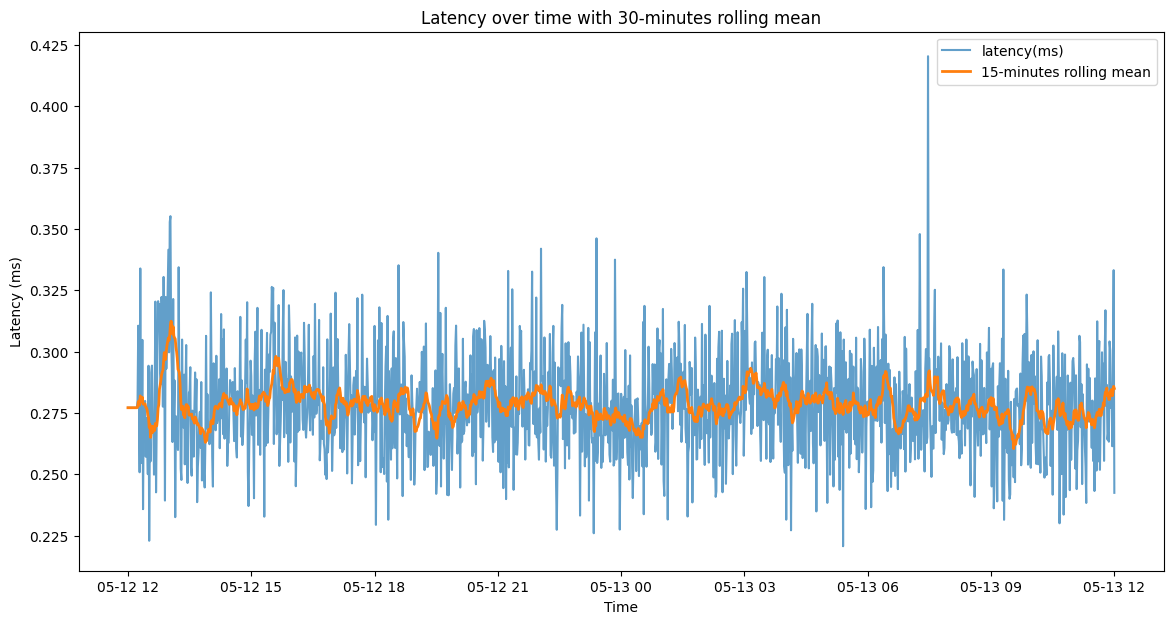

In [8]:
# Perform a rolling mean with a window of 15 minutes
df_one_day_format["rolling_mean_latency"] = df_one_day_format["latency(ms)"].rolling(window=15, min_periods=1).mean()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_one_day_format.index, df_one_day_format["latency(ms)"], label="latency(ms)", alpha=0.7)
plt.plot(df_one_day_format.index, df_one_day_format["rolling_mean_latency"], label="15-minutes rolling mean", linewidth=2)
plt.title("Latency over time with 30-minutes rolling mean")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [9]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_one_day_format.drop(columns=["rolling_mean_latency"])
y = df_one_day_format["rolling_mean_latency"]

In [ ]:
# Scale the data using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Define two different scaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scalers
X_scaled = feature_scaler.fit_transform(X)
# Convert 1D to 2D array, which -1 means "as many rows as needed"
# and 1 means one column
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, y_scaled, test_size=0.2,
  shuffle=False
)

### Data Visualization

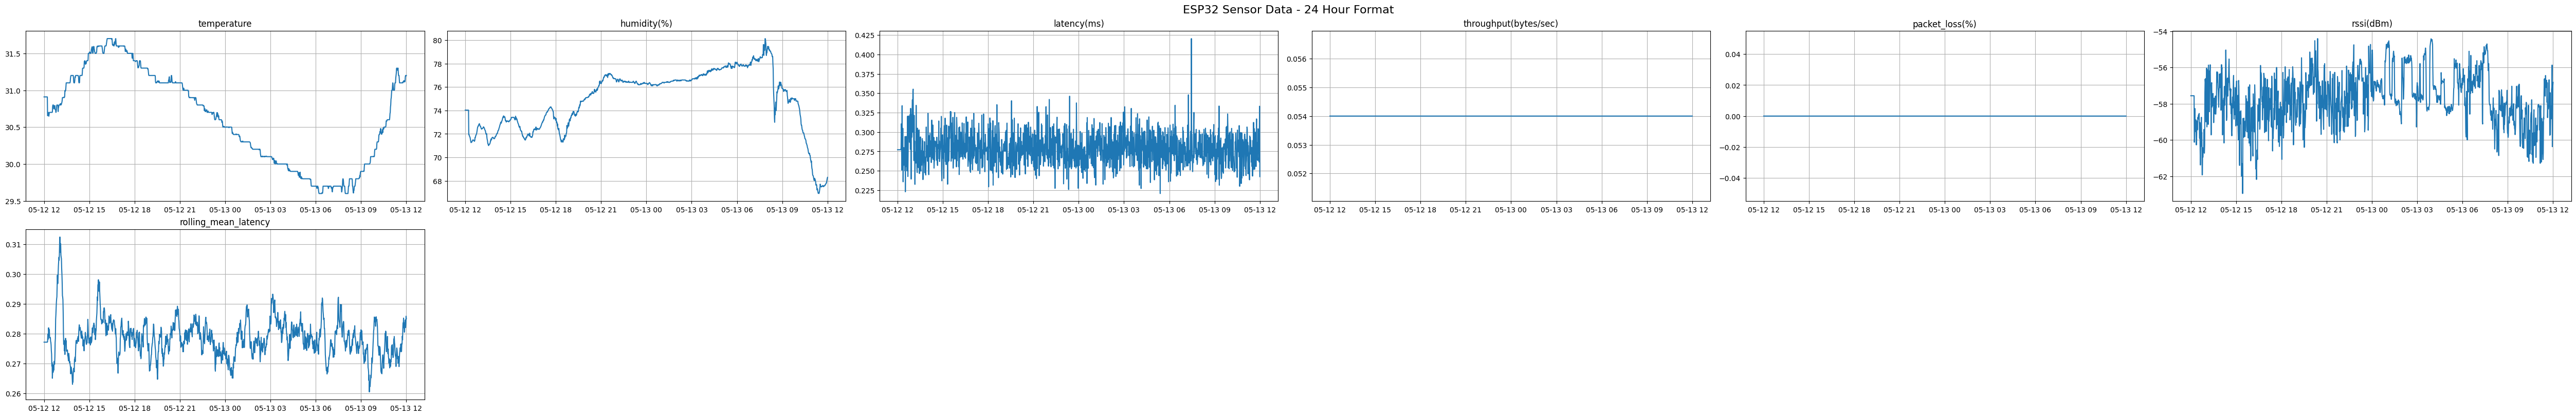

In [11]:
# Define num of rows and columns for the subplots
num_cols = 6
num_rows = int(np.ceil(len(df_one_day_format.columns) / num_cols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 8), constrained_layout=True)

# Flatten the axes array for iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(df_one_day_format.columns):
  axes[i].plot(df_one_day_format[column])
  axes[i].set_title(column)
  axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

# Set the overall title for the figure
fig.suptitle("ESP32 Sensor Data - 24 Hour Format", fontsize=16)
plt.show()

## Simple RNN Model

In [12]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

# Define optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001) 

In [13]:
# Model building
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate 
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model.add(Dense(units=1))  # Output layer for regression

# Define optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001) 

# Compile the model
model.compile(optimizer=adam, loss="mean_squared_error", metrics=["mae"])
model.summary()  # Display the model summary

c:\Project\iot-network-digital-twin\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 6, 100)         │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Implement EarlyStopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=10,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for RNN input
  y_train.reshape(-1, 1), # Reshape y_train for RNN input
  epochs=100,
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for RNN input
    y_test.reshape(-1, 1) # Reshape y_test for RNN input
  ),
  verbose=1
)

Epoch 1/100


c:\Project\iot-network-digital-twin\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1711 - mae: 0.3225 - val_loss: 0.0171 - val_mae: 0.1070
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0353 - mae: 0.1466 - val_loss: 0.0120 - val_mae: 0.0868
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0273 - mae: 0.1249 - val_loss: 0.0106 - val_mae: 0.0816
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0224 - mae: 0.1143 - val_loss: 0.0102 - val_mae: 0.0795
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0224 - mae: 0.1117 - val_loss: 0.0109 - val_mae: 0.0836
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0195 - mae: 0.1081 - val_loss: 0.0101 - val_mae: 0.0797
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0197 - mae: 0.1051 - val_loss: 0.0112 - val_mae: 0.0850
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0204 - mae: 0.1092 - val_loss: 0.0127 - val_mae: 0.0923
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0186 -

### RNN Model Predict

In [15]:
# Predict on the test set
predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions = target_scaler.inverse_transform(predictions)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

c:\Project\iot-network-digital-twin\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


## LSTM Model

In [16]:
# Model building
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(LSTM(units=100, return_sequences=False))
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(Dense(units=1))  # Output layer for regression

# Define optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001) 

# Compile the model
model_lstm.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])
model_lstm.summary()

c:\Project\iot-network-digital-twin\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history_lstm = model_lstm.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for RNN input
  y_train.reshape(-1, 1), # Reshape y_train for RNN input
  epochs=100,
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for RNN input
    y_test.reshape(-1, 1) # Reshape y_test for RNN input
  ),
  verbose=1
)

Epoch 1/100


c:\Project\iot-network-digital-twin\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0166 -

### LSTM Model Predict

In [18]:
# Predict on the test set
predictions_lstm = model_lstm.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


## GRU Model

In [19]:
# Model building
model_gru = Sequential()
model_gru.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_gru.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_gru.add(GRU(units=100, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))  # Output layer for regression

# Define optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001) 

# Compile the model
model_gru.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])
model_gru.summary()

c:\Project\iot-network-digital-twin\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 6, 100)         │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,601 (357.82 KB)

 Trainable params: 91,601 (357.82 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history_gru = model_gru.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for GRU input
  y_train.reshape(-1, 1), # Reshape y_train for GRU input
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for GRU input
    y_test.reshape(-1, 1) # Reshape y_test for GRU input
  ),
  epochs=100,
  verbose=1
)

Epoch 1/100


c:\Project\iot-network-digital-twin\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss:

### GRU Model Predict

In [21]:
# Predict on the test set
predictions_gru = model_gru.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_gru = target_scaler.inverse_transform(predictions_gru)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Perform evaluation with metrics
mae = mean_absolute_error(y_test_unscaled, predictions)
mse = mean_squared_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


### Performance Metrics

In [22]:
# Define a list of model predictions and names for evaluation
model_predictions_list = [predictions, predictions_lstm, predictions_gru]
model_names = ["SimpleRNN", "LSTM", "GRU"]
metrics_list = []

# Itearate through the model predictions and calculate metrics
for i, model in enumerate(model_predictions_list):
  mae = mean_absolute_error(y_test_unscaled, model)
  mse = mean_squared_error(y_test_unscaled, model)
  r2 = r2_score(y_test_unscaled, model)
  mape = mean_absolute_percentage_error(y_test_unscaled, model)
  rmse = np.sqrt(mse)
  metrics_list.append({
    "Model": model_names[i],
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R2": r2,
  })

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index("Model", inplace=True)
metrics_df

,MAE,MSE,RMSE,MAPE,R2
Model,,,,,
SimpleRNN,0.004117,0.000027,0.005204,0.014908,0.113156
LSTM,0.004139,0.000027,0.005151,0.014996,0.130804
GRU,0.004012,0.000026,0.005087,0.014522,0.152366


### Visualize Results

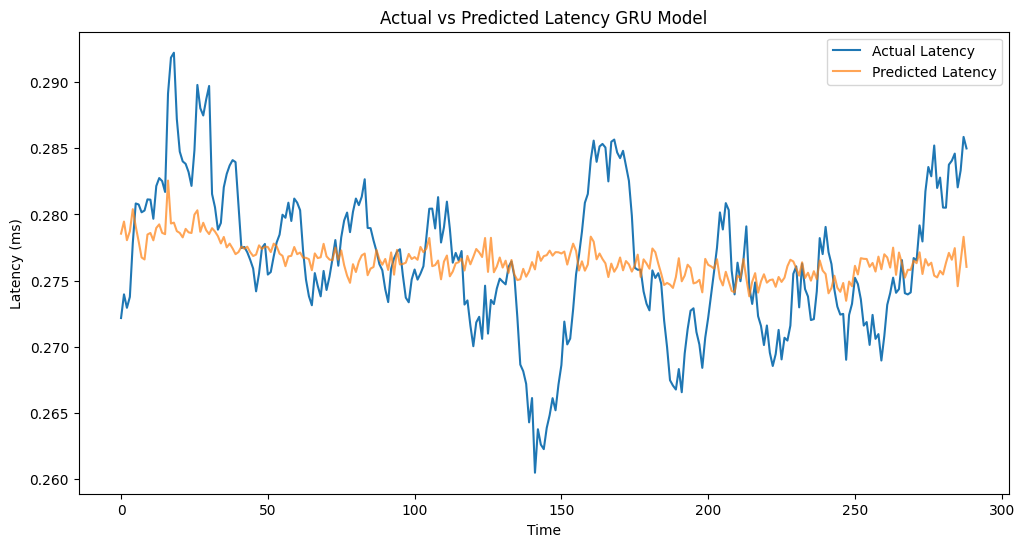

In [23]:
# Visualize the predictions for GRU model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_gru, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency GRU Model")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

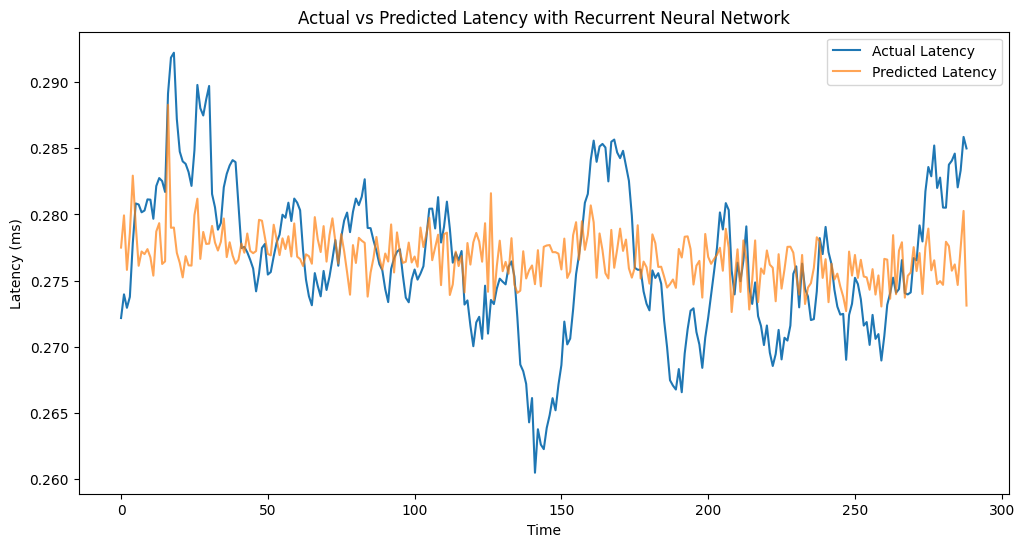

In [24]:
# Visualize the predictions for SimpleRNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency with Recurrent Neural Network")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

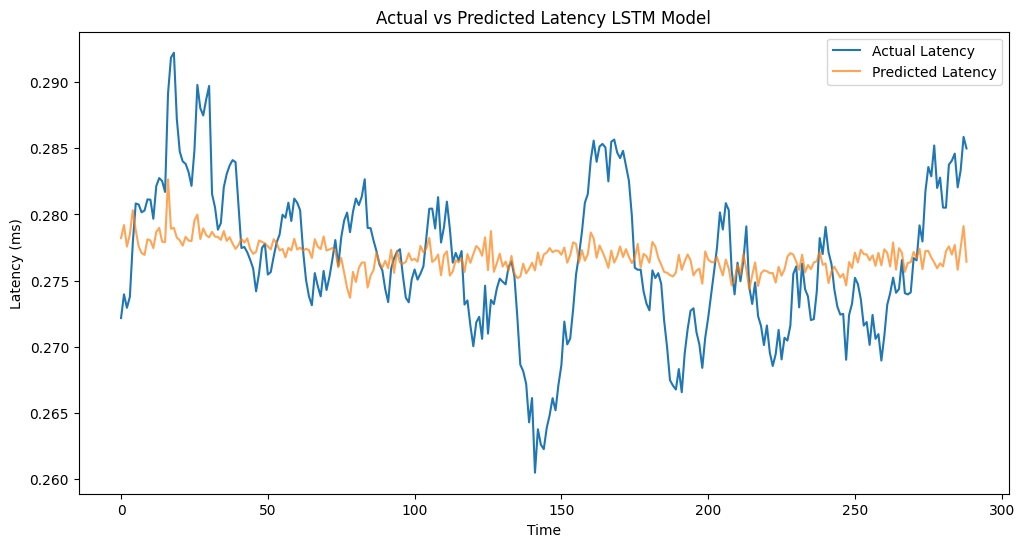

In [25]:
# Visualize the predictions for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_lstm, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency LSTM Model")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()